In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Variance reductions
- Logistic regression unless stated otherwise. 
### newlogistic (simulated, d=10)
- 30/60% independent, 80% dependent. (30% = Shapley Sampling, 60% = KernelSHAP)
### bank
- 16 features, 48 binarized
- bank is w/ neural net; bank_logit w/ logistic regression
- logistic regression: 75-85% inininininindependent, 60-70% independent. 
- neural net: 0/20% independent, 40% dependent. 
### brca (d=100): works, but bad results & buggy
- KernelSHAP always fails, for both independent & correlated features
- On Shapley Sampling, variance reductions are usually ~5% (wider spread for independent features)
### census: incomplete
- 12 features, 91
- Logistic Regression: only ran for one point, 5 iterations. will need to average
    - good for dependent (median 85%); awful for independent (half below 1). 
- Light GBM (census_giles, finite differencing). Only run on 1 point, 1 repetition.
    - independent features btwn 0-25% (similar SS & KSHAP)
    - correlated features 20-50%


In [13]:
from scipy.stats import rankdata
import numpy as np
import matplotlib.pyplot as plt


fname = '../GilesCode/bank_logit'
# #pts x #iters x #outputs x #features
kshaps_indep = np.load(fname+'_kshap_indep.npy')
sss_indep = np.load(fname+'_ss_indep.npy')
kshaps_dep = np.load(fname+'_kshap_dep.npy')
sss_dep = np.load(fname+'_ss_dep.npy')

n_pts, nsim_per_point, h, d = kshaps_indep.shape

In [124]:
kshaps_dep = np.array(kshaps_dep)
kshaps_indep = np.array(kshaps_indep)

sss_dep = np.array(sss_dep)
sss_indep = np.array(sss_indep)

means_kshap_dep = np.mean(kshaps_dep,axis=1)
means_kshap_indep = np.mean(kshaps_indep,axis=1)
vars_kshap_dep = np.var(kshaps_dep,axis=1)
vars_kshap_indep = np.var(kshaps_indep,axis=1)

means_ss_dep = np.mean(sss_dep,axis=1)
means_ss_indep = np.mean(sss_indep,axis=1)
vars_ss_dep = np.var(sss_dep,axis=1)
vars_ss_indep = np.var(sss_indep,axis=1)

var_reducs_indep = 1-np.array([[vars_ss_indep[i][0]/vars_ss_indep[i][1] for i in range(n_pts)],
                    #[vars_kshap_indep[i][2]/vars_kshap_indep[i][0] for i in range(n_pts)],
                    [vars_kshap_indep[i][6]/vars_kshap_indep[i][0] for i in range(n_pts)]])

reducs_indep_25 = np.reshape(np.quantile(var_reducs_indep,0.25,axis=1).T,[2*d])
reducs_indep_50 = np.reshape(np.quantile(var_reducs_indep,0.50,axis=1).T,[2*d])
reducs_indep_75 = np.reshape(np.quantile(var_reducs_indep,0.75,axis=1).T,[2*d])



var_reducs_dep = 1-np.array([[vars_ss_dep[i][0]/vars_ss_dep[i][1] for i in range(n_pts)],
                    #[vars_kshap_dep[i][2]/vars_kshap_dep[i][0] for i in range(n_pts)],
                    [vars_kshap_dep[i][6]/vars_kshap_dep[i][0] for i in range(n_pts)]])


reducs_dep_25 = np.reshape(np.quantile(var_reducs_dep,0.25,axis=1).T,[2*d])
reducs_dep_50 = np.reshape(np.quantile(var_reducs_dep,0.50,axis=1).T,[2*d])
reducs_dep_75 = np.reshape(np.quantile(var_reducs_dep,0.75,axis=1).T,[2*d])

xpts = np.repeat( np.arange(0,d), 2) + np.tile(np.array([-0.1,0.1]),d)

# plot independent then dependent
# fig1 = plt.errorbar(xpts,reducs_indep_50,yerr=np.array([reducs_indep_50-reducs_indep_25,reducs_indep_75-reducs_indep_50]),fmt='o')
# plt.errorbar(xpts,reducs_dep_50,yerr=np.array([reducs_dep_50-reducs_dep_25,reducs_dep_75-reducs_dep_50]),fmt='o')
# plt.ylim([-0.25,1])
# plt.axhline(y=0,color='black')

global_shap_indep = np.sum(np.abs(np.mean(sss_indep, axis=1)[:,1,:]), axis=0)
global_shap_indep_scaled = global_shap_indep/np.max(global_shap_indep)*0.3
order_indep = np.argsort(global_shap_indep_scaled)[::-1]
order_indep2 = np.array([order_indep*2, order_indep*2+1]).reshape(-1, order='F')
y_arr = np.array([reducs_indep_50-reducs_indep_25,reducs_indep_75-reducs_indep_50])

global_shap_dep = np.sum(np.abs(np.mean(sss_dep, axis=1)[:,1,:]), axis=0)
global_shap_dep_scaled = global_shap_dep/np.max(global_shap_dep)*0.3
# order_dep = np.argsort(global_shap_dep_scaled)[::-1]
# order_dep2 = np.array([order_dep*2, order_dep*2+1]).reshape(-1, order='F')
y_arr = np.array([reducs_dep_50-reducs_dep_25,reducs_dep_75-reducs_dep_50])

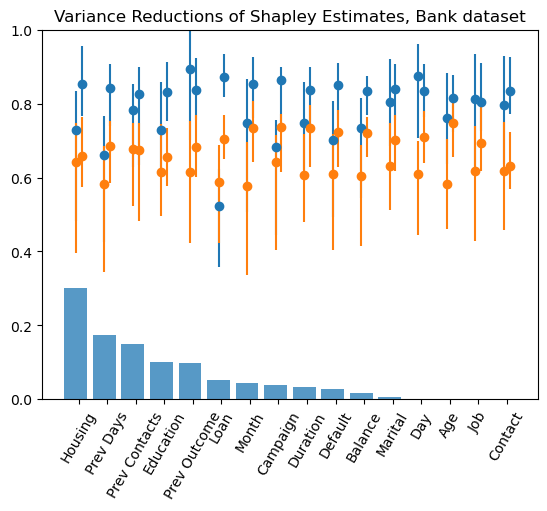

In [128]:
import sage
plt.errorbar(xpts,reducs_indep_50[order_indep2],yerr=y_arr[:,order_indep2],fmt='o')
plt.errorbar(xpts,reducs_dep_50[order_indep2],yerr=y_arr[:,order_indep2],fmt='o')

plt.bar(np.arange(d)-.1,global_shap_indep_scaled[order_indep], alpha=0.75)
# plt.bar(np.arange(d)+.1,global_shap_dep_scaled[order_indep], alpha=0.75) # Smoother, wrong order

plt.ylim([0,1])
plt.title("Variance Reductions of Shapley Estimates, Bank dataset")
# fig, ax = plt.subplots()
# ax.tick_params(labelbottom=False)    

df_orig = sage.datasets.bank()
colnames = df_orig.columns[:d]
plt.xticks(np.arange(d), colnames[order_indep], rotation=60)

plt.show()

In [95]:
# global_shap_indep = np.sum(np.abs(np.mean(sss_indep, axis=1)[:,1,:]), axis=0)
# global_shap_indep_scaled = global_shap_indep/np.max(global_shap_indep)*np.min(reducs_indep_25)
# order_indep = np.argsort(global_shap_indep_scaled)[::-1]
# order_indep2 = np.array([order_indep*2, order_indep*2+1]).reshape(-1, order='F')
# y_arr = np.array([reducs_indep_50-reducs_indep_25,reducs_indep_75-reducs_indep_50])

# plt.errorbar(xpts,reducs_indep_50[order_indep2],yerr=y_arr[:,order_indep2],fmt='o')
# plt.bar(list(range(16)),global_shap_indep_scaled[order_indep])


# global_shap_dep = np.sum(np.abs(np.mean(sss_dep, axis=1)[:,1,:]), axis=0)
# global_shap_dep_scaled = global_shap_dep/np.max(global_shap_dep)*np.min(reducs_dep_25)
# order_dep = np.argsort(global_shap_dep_scaled)[::-1]
# order_dep2 = np.array([order_dep*2, order_dep*2+1]).reshape(-1, order='F')
# y_arr = np.array([reducs_dep_50-reducs_dep_25,reducs_dep_75-reducs_dep_50])

# plt.errorbar(xpts,reducs_dep_50[order_dep2],yerr=y_arr[:,order_dep2],fmt='o')
# plt.bar(list(range(16)),global_shap_dep_scaled[order_dep])

